In [1]:
#pip install influxdb


## Step 1: Data Fetching 


In [2]:
from influxdb import InfluxDBClient
import datetime
import pandas as pd
from termcolor import colored
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [3]:
# Set the needed parameters to connect to the database

settings = {
    'host': 'influxus.itu.dk',
    'port': 8086,
    'username': 'lsda',
    'password': 'icanonlyread'
    }

# Create an InfluxDB Client instance and select the orkney database

client = InfluxDBClient(host=settings['host'], port=settings['port'], username=settings['username'], password=settings['password'])
client.switch_database('orkney')

In [4]:
## Function to tranform the InfluxDB resulting set into a Dataframe
def set_to_dataframe(resulting_set):
    
    values = resulting_set.raw["series"][0]["values"]
    columns = resulting_set.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index

    return df

In [5]:
days = 90 # -> You can change this to get any other range of days

### YOU DON'T NEED TO CHANGE ANYTHING HERE ###
power_set = client.query(
    "SELECT * FROM Generation where time > now()-"+str(days)+"d"
    ) # Query written in InfluxQL. We are retrieving all generation data from 90 days back.

# Get the last 90 days of weather forecasts with the shortest lead time
wind_set  = client.query(
    "SELECT * FROM MetForecasts where time > now()-"+str(days)+"d and time <= now() and Lead_hours = '1'"
    ) # Query written in InfluxQL. We are retrieving all weather forecast data from 90 days back and with 1 lead hour.

power_df = set_to_dataframe(power_set)
wind_df = set_to_dataframe(wind_set)

In [6]:
# data taken every minute
power_df.head()



,ANM,Non-ANM,Total
time,,,
2024-01-27 11:53:00+00:00,8.482847,11.911,20.393847
2024-01-27 11:54:00+00:00,8.415765,12.050,20.465765
2024-01-27 11:55:00+00:00,8.315757,11.949,20.264757
2024-01-27 11:56:00+00:00,8.330100,11.779,20.109100
2024-01-27 11:57:00+00:00,8.322640,12.185,20.507640


In [7]:
# data taken every 3 hours
wind_df.reset_index()

,time,Direction,Lead_hours,Source_time,Speed
0,2024-01-27 12:00:00+00:00,WSW,1,1706349600,12.96416
1,2024-01-27 15:00:00+00:00,WSW,1,1706360400,13.85824
2,2024-01-28 03:00:00+00:00,S,1,1706403600,12.96416
3,2024-01-28 06:00:00+00:00,S,1,1706414400,12.07008
4,2024-01-28 09:00:00+00:00,S,1,1706425200,13.85824
...,...,...,...,...,...
698,2024-04-25 21:00:00+00:00,N,1,1714068000,4.91744
699,2024-04-26 00:00:00+00:00,NNE,1,1714078800,4.91744
700,2024-04-26 03:00:00+00:00,NE,1,1714089600,5.81152
701,2024-04-26 06:00:00+00:00,NNE,1,1714100400,4.02336


In [8]:
# Saving power_df to CSV
power_df.to_csv('power_data.csv', index=True)

# Saving wind_df to CSV
wind_df.to_csv('wind_data.csv', index=True)


In [9]:
power_df = power_df.reset_index()
print(power_df.head())


                       time       ANM  Non-ANM      Total
0 2024-01-27 11:53:00+00:00  8.482847   11.911  20.393847
1 2024-01-27 11:54:00+00:00  8.415765   12.050  20.465765
2 2024-01-27 11:55:00+00:00  8.315757   11.949  20.264757
3 2024-01-27 11:56:00+00:00  8.330100   11.779  20.109100
4 2024-01-27 11:57:00+00:00  8.322640   12.185  20.507640


In [10]:
# Encoding the direction of the wnd into degrees
direction_set = set(wind_df['Direction'])
#print(direction_set)

# Mapping dictionary from degrees from http://tamivox.org/dave/compass/
direction_mapping = {
    'N': 0,
    'NNE': 23,
    'NE': 45,
    'ENE': 67,
    'E': 90,
    'ESE': 112,
    'SE': 135,
    'SSE': 152,
    'S': 180,
    'SSW': 202,
    'SW': 225,
    'WSW': 247,
    'W': 270,
    'WNW': 293,
    'NW': 315,
    'NNW': 337
}

# Convert direction strings to numerical values
wind_df['Direction_Degrees'] = wind_df['Direction'].map(direction_mapping)
print(wind_df.head())


                          Direction Lead_hours  Source_time     Speed  \
time                                                                    
2024-01-27 12:00:00+00:00       WSW          1   1706349600  12.96416   
2024-01-27 15:00:00+00:00       WSW          1   1706360400  13.85824   
2024-01-28 03:00:00+00:00         S          1   1706403600  12.96416   
2024-01-28 06:00:00+00:00         S          1   1706414400  12.07008   
2024-01-28 09:00:00+00:00         S          1   1706425200  13.85824   

                           Direction_Degrees  
time                                          
2024-01-27 12:00:00+00:00                247  
2024-01-27 15:00:00+00:00                247  
2024-01-28 03:00:00+00:00                180  
2024-01-28 06:00:00+00:00                180  
2024-01-28 09:00:00+00:00                180  


In [11]:
wind_df = wind_df.reset_index()
print(wind_df.head())

                       time Direction Lead_hours  Source_time     Speed  \
0 2024-01-27 12:00:00+00:00       WSW          1   1706349600  12.96416   
1 2024-01-27 15:00:00+00:00       WSW          1   1706360400  13.85824   
2 2024-01-28 03:00:00+00:00         S          1   1706403600  12.96416   
3 2024-01-28 06:00:00+00:00         S          1   1706414400  12.07008   
4 2024-01-28 09:00:00+00:00         S          1   1706425200  13.85824   

   Direction_Degrees  
0                247  
1                247  
2                180  
3                180  
4                180  


In [12]:
merged = pd.merge(power_df, wind_df, on = "time", how='left')
row_200 = merged.iloc[199]
print(row_200)

time                 2024-01-27 15:34:00+00:00
ANM                                   3.753769
Non-ANM                                 14.386
Total                                18.139769
Direction                                  NaN
Lead_hours                                 NaN
Source_time                                NaN
Speed                                      NaN
Direction_Degrees                          NaN
Name: 199, dtype: object


In [13]:

# Dropping the non needed columns 

columns_to_remove = ['time','ANM','Non-ANM','Direction', 'Lead_hours', 'Source_time']
merged.drop(columns=columns_to_remove, inplace=True)


In [14]:
merged.shape
merged.head

<bound method NDFrame.head of            Total  Speed  Direction_Degrees
0      20.393847    NaN                NaN
1      20.465765    NaN                NaN
2      20.264757    NaN                NaN
3      20.109100    NaN                NaN
4      20.507640    NaN                NaN
...          ...    ...                ...
82044   1.250540    NaN                NaN
82045   1.237995    NaN                NaN
82046   1.191319    NaN                NaN
82047   1.182432    NaN                NaN
82048   1.249819    NaN                NaN

[82049 rows x 3 columns]>

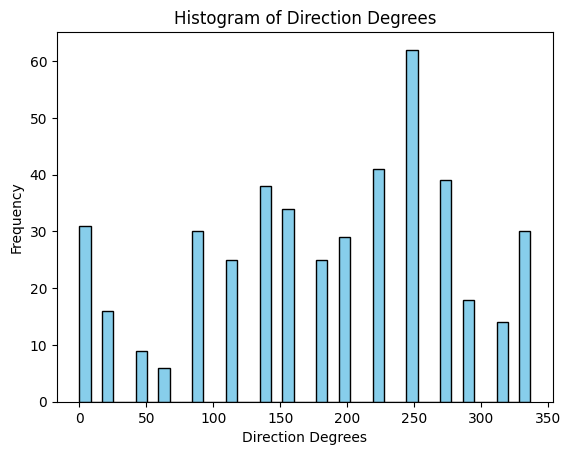

In [15]:
plt.hist(merged['Direction_Degrees'], bins=40, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Direction Degrees')
plt.ylabel('Frequency')
plt.title('Histogram of Direction Degrees')

# Show the plot
plt.show()

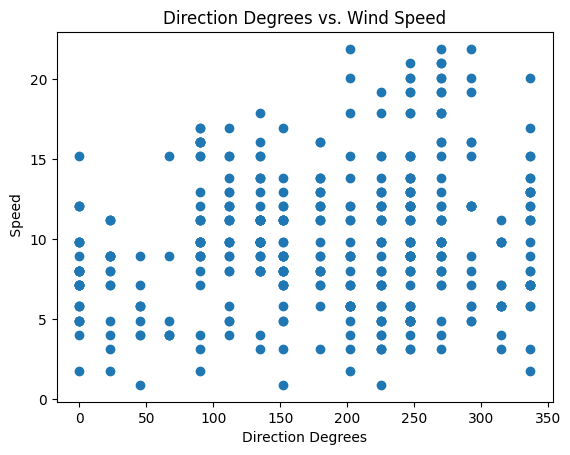

In [16]:
plt.scatter(merged['Direction_Degrees'],merged['Speed'])
plt.xlabel('Direction Degrees')
plt.ylabel(' Speed')
plt.title('Direction Degrees vs. Wind Speed')
plt.show()


In [17]:
newdf = merged.interpolate(method='bfill')
#newdf.head()

In [18]:
newdf.to_csv('full_data.csv')


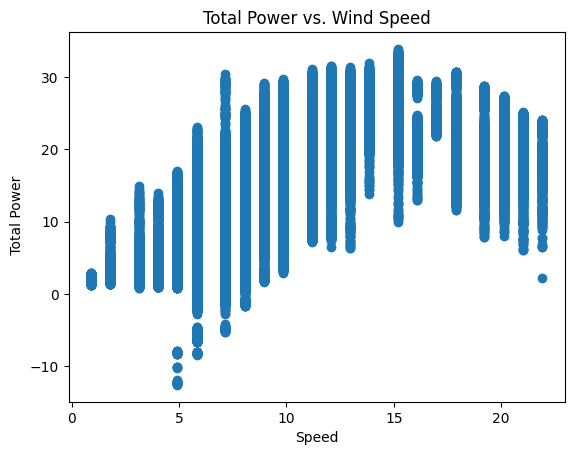

In [19]:


# Plotting mean_total against speed
plt.scatter(newdf['Speed'], newdf['Total'])
plt.xlabel('Speed')
plt.ylabel(' Total Power')
plt.title('Total Power vs. Wind Speed')
plt.show()


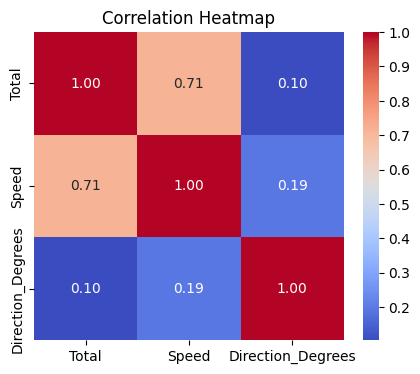

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(newdf.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## EDA

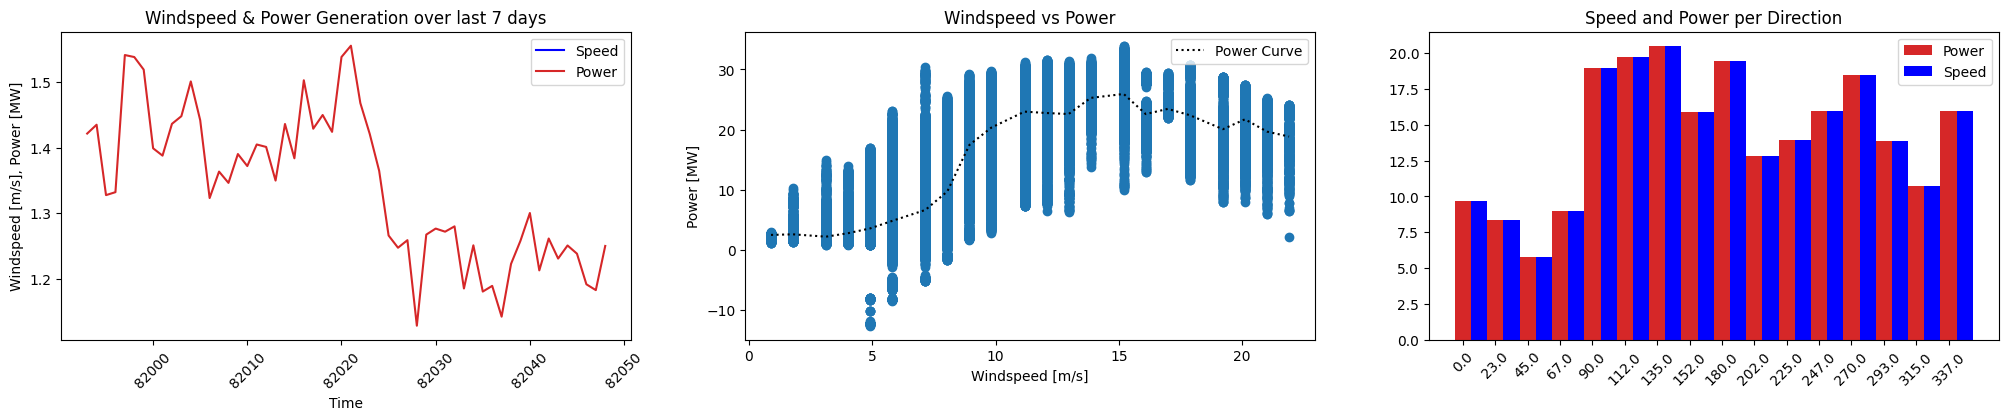

In [21]:
# Subplots
fig, ax = plt.subplots(1,3, figsize=(25,4))

# Speed and Power for the last 7 days
ax[0].plot(newdf["Speed"].tail(int(7*24/3)), label="Speed", color="blue") # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
ax[0].plot(newdf["Total"].tail(int(7*24/3)), label="Power", color="tab:red") # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
ax[0].set_title("Windspeed & Power Generation over last 7 days")
ax[0].set_xlabel("Time")
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_ylabel("Windspeed [m/s], Power [MW]")
ax[0].legend()

# Speed vs Total (Power Curve nature)
ax[1].scatter(newdf["Speed"], newdf["Total"])
power_curve = newdf.groupby("Speed").median(numeric_only=True)["Total"]
ax[1].plot(power_curve.index, power_curve.values, "k:", label="Power Curve")
ax[1].legend()
ax[1].set_title("Windspeed vs Power")
ax[1].set_ylabel("Power [MW]")
ax[1].set_xlabel("Windspeed [m/s]")

# Speed and Power per Wind Direction
wind_grouped_by_direction = newdf.groupby("Direction_Degrees").mean(numeric_only=True).reset_index()
bar_width = 0.5
x = np.arange(len(wind_grouped_by_direction.index))

ax[2].bar(x, wind_grouped_by_direction.Total, width=0.5, label="Power", color="tab:red")
ax[2].bar(x + bar_width, wind_grouped_by_direction.Total, width=0.5, label="Speed", color="blue")
ax[2].legend()
ax[2].set_xticks(x)
ax[2].set_xticklabels(wind_grouped_by_direction.Direction_Degrees)
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Speed and Power per Direction");

In [22]:
newdf.shape

(82049, 3)

In [23]:
newdf.dropna(how='all')
newdf.dropna(axis='columns')

,Total
0,20.393847
1,20.465765
2,20.264757
3,20.109100
4,20.507640
...,...
82044,1.250540
82045,1.237995
82046,1.191319
82047,1.182432


In [24]:
# Count NA values in each column
na_counts = newdf.isna().sum()

# Print the result
print(na_counts)

Total                  0
Speed                172
Direction_Degrees    172
dtype: int64


In [25]:
newdf.shape

(82049, 3)

In [26]:
df_cleaned = newdf.dropna()

In [27]:
df_cleaned.shape
df_cleaned.head()

,Total,Speed,Direction_Degrees
0,20.393847,12.96416,247.0
1,20.465765,12.96416,247.0
2,20.264757,12.96416,247.0
3,20.109100,12.96416,247.0
4,20.507640,12.96416,247.0


## Step 2 Pipeline and data transformations

In [28]:
# A very basic pipeline
pipeline_example = Pipeline([
    # Transformations
    ("Scaler", StandardScaler()),
    # Estimator
    ("Linear Regression", LinearRegression())
])

## Evaluate the models

In [29]:
from sklearn.model_selection import train_test_split

# Select our feature variables and our target variable.
X = df_cleaned["Speed"].values.reshape(-1, 1)
y = df_cleaned["Total"].values.reshape(-1, 1)

# Split the data into train, dev, and test sets
X_train_dev, X_test, y_train_dev, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) 

X_train, X_dev, y_train, y_dev = train_test_split(
    X_train_dev, y_train_dev, test_size=0.25, random_state=42
)

# Train our model
pipeline_example.fit(X_train, y_train)

# Evaluate the model, using MAE as a metric on the dev set
mae_dev = mean_absolute_error(pipeline_example.predict(X_dev), y_dev)
print("Mean Absolute Error on Dev Set:", mae_dev)

# Evaluate the model on the test set
mae_test = mean_absolute_error(pipeline_example.predict(X_test), y_test)
print("Mean Absolute Error on Test Set:", mae_test)


Mean Absolute Error on Dev Set: 5.167794328553377
Mean Absolute Error on Test Set: 5.160063290931588


In [30]:
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# Start MLflow run
with mlflow.start_run(run_name="Lin_regre_1feature_Speed") as run:

    # Define your pipeline
    pipeline_example = Pipeline([
        # Transformations
        ("Scaler", StandardScaler()),
        # Estimator
        ("Linear Regression", LinearRegression())
    ])

    # Select our feature variables and our target variable.
    X = df_cleaned["Speed"].values.reshape(-1,1)
    y = df_cleaned["Total"].values.reshape(-1,1)

 
    # Train our model on the train set
    pipeline_example.fit(X_train, y_train)

    # Evaluate the model on the dev set, using MAE as a metric
    mae_dev = mean_absolute_error(pipeline_example.predict(X_dev), y_dev)

    # Log parameters
    mlflow.log_param("model", "Linear Regression")
    mlflow.log_param("feature", "Speed")

    # Log metrics
    mlflow.log_metric("MAE on Dev Set", mae_dev)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_example, "model")


c:\Users\45911\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [31]:


# Start MLflow run
with mlflow.start_run(run_name="Lin_regre_1feature_Direction") as run:

    # Define your pipeline
    pipeline_example = Pipeline([
        # Transformations
        ("Scaler", StandardScaler()),
        # Estimator
        ("Linear Regression", LinearRegression())
    ])

    # Select our feature variables and our target variable.
    X = df_cleaned["Direction_Degrees"].values.reshape(-1,1)
    y = df_cleaned["Total"].values.reshape(-1,1)


    # Train our model on the train set
    pipeline_example.fit(X_train, y_train)

    # Evaluate the model on the dev set, using MAE as a metric
    mae_dev = mean_absolute_error(pipeline_example.predict(X_dev), y_dev)

    # Log parameters
    mlflow.log_param("model", "Linear Regression")
    mlflow.log_param("feature", "Direction")

    # Log metrics
    mlflow.log_metric("MAE on Dev Set", mae_dev)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_example, "model")


In [32]:


# Select our feature variables and our target variable.
X = df_cleaned[["Speed", "Direction_Degrees"]]
y = df_cleaned["Total"]


# Start MLflow run for Linear Regression model with 2 features
with mlflow.start_run(run_name="Lin_reg_2features") as run_lr_2_features:

    # Define your pipeline for Linear Regression with 2 features
    pipeline_lr_2_features = Pipeline([
        # Transformations
        ("Scaler", StandardScaler()),
        # Estimator
        ("Linear Regression", LinearRegression())
    ])

    # Train the Linear Regression model with 2 features on the train set
    pipeline_lr_2_features.fit(X_train, y_train)

    # Evaluate the model on the dev set, using MAE as a metric
    mae_lr_2_features_dev = mean_absolute_error(pipeline_lr_2_features.predict(X_dev), y_dev)

    # Log parameters for Linear Regression model with 2 features
    mlflow.log_param("model", "Linear Regression")
    mlflow.log_param("features", "Speed, Direction_Degrees")

    # Log metrics for Linear Regression model with 2 features
    mlflow.log_metric("MAE on Dev Set", mae_lr_2_features_dev)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_lr_2_features, "lr_2_features_model")

    # Print MAE for Linear Regression model with 2 features
    print("MAE (LR with 2 features) on Dev Set:", mae_lr_2_features_dev)

    # Retrieve the MLflow run ID for Linear Regression model with 2 features
    run_id_lr_2_features = run_lr_2_features.info.run_id
    print("MLflow Run ID (LR with 2 features):", run_id_lr_2_features)


MAE (LR with 2 features) on Dev Set: 5.167794328553377
MLflow Run ID (LR with 2 features): 7bfc40d3936a439e8c0143f210881582


In [33]:
from sklearn.neighbors import KNeighborsRegressor


with mlflow.start_run(run_name="KNN_Model") as run_knn:

    # Define your pipeline for KNN
    pipeline_knn = Pipeline([
        # Transformations (if necessary)
        ("Scaler", StandardScaler()),  # Scale features for better performance of KNN
        # Estimator
        ("KNN", KNeighborsRegressor())  # Initialize KNN model
    ])

    # Train the KNN model on the train set
    pipeline_knn.fit(X_train, y_train)

    # Evaluate the model on the dev set, using MAE as a metric
    mae_knn_dev = mean_absolute_error(pipeline_knn.predict(X_dev), y_dev)

    # Log parameters for KNN model
    mlflow.log_param("model", "K-Nearest Neighbors")
    mlflow.log_param("feature", "Speed, Direction_Degrees")

    # Log metrics for KNN model
    mlflow.log_metric("MAE on Dev Set", mae_knn_dev)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_knn, "knn_model")

    # Print MAE for KNN model on the dev set
    print("MAE (KNN) on Dev Set:", mae_knn_dev)

    # Retrieve the MLflow run ID for KNN model
    run_id_knn = run_knn.info.run_id
    print("MLflow Run ID (KNN):", run_id_knn)


MAE (KNN) on Dev Set: 3.800509175403029
MLflow Run ID (KNN): 4bae0e15e72f4185ad57445b2194087b


In [34]:
from sklearn.ensemble import RandomForestRegressor


# Select our feature variables and our target variable.
X = df_cleaned[["Speed", "Direction_Degrees"]]
y = df_cleaned["Total"]

# Start MLflow run for Random Forest model with a specific run name
with mlflow.start_run(run_name="RandomForest_Model") as run_rf:

    # Define your pipeline for Random Forest
    pipeline_rf = Pipeline([
        # Transformations (if necessary)
        ("Scaler", StandardScaler()),  # Scale features for better performance
        # Estimator
        ("RandomForest", RandomForestRegressor())  # Initialize Random Forest model
    ])

    # Split the data into train, dev, and test sets
    X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Splitting into 80% train/dev and 20% test
    X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.25, random_state=42)  # Splitting train/dev into 60% train and 20% dev

    # Train the Random Forest model on the train set
    pipeline_rf.fit(X_train, y_train)

    # Evaluate the model on the dev set, using MAE as a metric
    mae_rf_dev = mean_absolute_error(pipeline_rf.predict(X_dev), y_dev)

    # Log parameters for Random Forest model
    mlflow.log_param("model", "Random Forest")
    mlflow.log_param("feature", "Speed, Direction_Degrees")

    # Log metrics for Random Forest model
    mlflow.log_metric("MAE on Dev Set", mae_rf_dev)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_rf, "random_forest_model")

    # Print MAE for Random Forest model on the dev set
    print("MAE (Random Forest) on Dev Set:", mae_rf_dev)

    # Retrieve the MLflow run ID for Random Forest model
    run_id_rf = run_rf.info.run_id
    print("MLflow Run ID (Random Forest):", run_id_rf)


MAE (Random Forest) on Dev Set: 2.659695366934548
MLflow Run ID (Random Forest): 8a5a138b00ef4fb5a07627c7361eca13


In [35]:
import pickle
# Save the trained model as a pickle file
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(pipeline_rf, f)



In [36]:
# Load the trained model from the pickle file
with open("random_forest_model.pkl", "rb") as f:
    loaded_model1 = pickle.load(f)

In [37]:
# Use the loaded model to make predictions on the test data
predictions = loaded_model1.predict(X_test)

# Evaluate the predictions using mean absolute error (MAE)
mae_test = mean_absolute_error(predictions, y_test)

print("MAE on Test Set:", mae_test)

MAE on Test Set: 2.6737918896018327


In [38]:
from sklearn.model_selection import GridSearchCV

# Define the parameters
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',  # Use MAE as the scoring metric
                           cv=5,  # 5-fold cross-validation
                           verbose=2,  # Increase verbosity to see progress
                           n_jobs=-1)  # Use all available CPU cores

# Perform grid search on the dev data
grid_search.fit(X_dev, y_dev)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Negative MAE:", best_score)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Best Negative MAE: 2.6769525559107343


In [39]:


# Select our feature variables and our target variable.
X = df_cleaned[["Speed", "Direction_Degrees"]]
y = df_cleaned["Total"]

# Define the best parameters found during grid search
best_params = {
    'n_estimators': 100,    'max_depth': 10,    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'auto'
}

# Start MLflow run for Random Forest model with a specific run name
with mlflow.start_run(run_name="RandomForest_Model_Tuned") as run_rf:

    # Define your pipeline for Random Forest with the best parameters
    pipeline_rf = Pipeline([
        # Transformations (if necessary)
        ("Scaler", StandardScaler()),  # Scale features for better performance
        # Estimator
        ("RandomForest", RandomForestRegressor(**best_params))  # Initialize Random Forest model with best parameters
    ])

    # Split the data into train, dev, and test sets
    X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Splitting into 80% train/dev and 20% test
    X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.25, random_state=42)  # Splitting train/dev into 60% train and 20% dev

    # Train the Random Forest model on the train set
    pipeline_rf.fit(X_train, y_train)

    # Evaluate the model on the dev set, using MAE as a metric
    mae_rf_dev = mean_absolute_error(pipeline_rf.predict(X_dev), y_dev)

    # Log parameters for Random Forest model
    mlflow.log_param("model", "Random Forest")
    mlflow.log_param("feature", "Speed, Direction_Degrees")

    # Log metrics for Random Forest model
    mlflow.log_metric("MAE on Dev Set", mae_rf_dev)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_rf, "random_forest_model")

    # Print MAE for Random Forest model on the dev set
    print("MAE (Random Forest) on Dev Set:", mae_rf_dev)

    # Retrieve the MLflow run ID for Random Forest model
    run_id_rf = run_rf.info.run_id
    print("MLflow Run ID (Random Forest):", run_id_rf)



c:\Users\45911\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


MAE (Random Forest) on Dev Set: 2.673561970562075
MLflow Run ID (Random Forest): 1a1adbb5c2744b038fcfe5f641405a19


In [40]:
import pickle
# Save the trained model as a pickle file
with open("random_forest_model_tuned.pkl", "wb") as f:
    pickle.dump(pipeline_rf, f)



In [41]:
# Load the trained model from the pickle file
with open("random_forest_model_tuned.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [42]:
# Use the loaded model to make predictions on the test data
predictions = loaded_model.predict(X_test)

# Evaluate the predictions using mean absolute error (MAE)
mae_test = mean_absolute_error(predictions, y_test)

print("MAE on Test Set:", mae_test)

MAE on Test Set: 2.6870819816576192
